# Logic Gate Task

This task utilizes a simple neural network containing single n-task context layer to learn eight different logic gates.

**Note:** This experiment uses a variation of the traditional n-task model to incorporate learning between batches instead of applying gradients at the end of batches. The idea is that learning will be much faster and more stable while retaining the ability to switch on bad contexts.

In [1]:
%load_ext autoreload

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

import datetime
import numpy as np
import os
import scipy.stats

import matplotlib as mpl
import matplotlib.pyplot as plt

# Import n-task
from ntask.atrs import AtrMovingAverage
from ntask.callbacks import AtrLogger
from ntask.flags import Verbosity
from ntask.layers import Context
from ntask.models import NTaskModel
from ntask.training import train, evaluate
from ntask.utils import set_seed

___

## Experimentation Setup

The following cells here build everything up for the experiments to execute

### Dataset Creation

The following cell creates the base dataset with all of the gates.

In [3]:
# Define the gates explicitly
gates = {
    "xor":      [0, 1, 1, 0],
    "xnor":     [1, 0, 0, 1],
    "and":      [0, 0, 0, 1],
    "or":       [0, 1, 1, 1],
    "nor":      [1, 0, 0, 0],
    "nand":     [1, 1, 1, 0],
    "custom_1": [1, 0, 1, 0],
    "custom_2": [0, 1, 0, 1]
}

# Build the labels used for `y_train` to work with the `train` convenience function
y_labels = [np.array([[i] for i in gate]) for gate in gates.values()]

# The inputs for each of the gates
x_train = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])

### Model Architecture and Creation

The following function creates a new instance of the model for each experiment. The hyperparameters are provided as arguments. The model summary is also displayed.

In [4]:
def create_model(tag, optimizer, num_contexts, max_contexts=0, switch_threshold=0.0, add_threshold=0.0, summary=True):
    # Model architecture
    inp = Input((2,))
    x = Dense(hrr_size, activation="relu")(inp)
    x = Context(
        num_contexts,
        AtrMovingAverage(max_contexts=max_contexts, switch_threshold=switch_threshold, add_threshold=add_threshold),
        name="Gate_Context"
    )(x)
    x = Dense(1, activation="sigmoid")(x)
    model = NTaskModel(inputs=inp, outputs=x)
    
    # Compile the model together with binary_crossentropy loss
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[
            tf.keras.metrics.BinaryAccuracy()
        ]
    )
    
    # Display the model summary
    if summary:
        model.summary()
    
    return model

___

## Experimentation

### 1. Static n-task: (XOR, XNOR)

The following experiments demonstrates the model successfully learning two separate logic gates.

In [14]:
TAG = "static-2-gate"

#### Dataset

In [15]:
y_train = y_labels[:2]

#### Seeding

In [16]:
set_seed(5)

#### Model Creation

In [8]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size         = 128
num_contexts     = len(y_train)
switch_threshold = -0.02

# Create the model
model = create_model(TAG, optimizer, num_contexts=len(y_train), switch_threshold=switch_threshold)

Model: "n_task_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               384       
_________________________________________________________________
Gate_Context (Context)       (None, 128)               260       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 773
Trainable params: 513
Non-trainable params: 260
_________________________________________________________________


#### Training

In [9]:
cycles     = 3
epochs     = 10
batch_size = 1

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True  # Shuffle the contexts during training after first epoch
initial_task_shuffle = True  # Shuffle the contexts before training

verbose = Verbosity.Contexts

logger = AtrLogger()
callbacks = [logger]

# Train the model
%time task_map, context_map = train(model, x_train, y_train, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)


[Gate_Context] Switched context to 1

[Gate_Context] Switched context to 0

[Gate_Context] Switched context to 1

[Gate_Context] Switched context to 0
CPU times: user 1.61 s, sys: 141 ms, total: 1.75 s
Wall time: 1.69 s


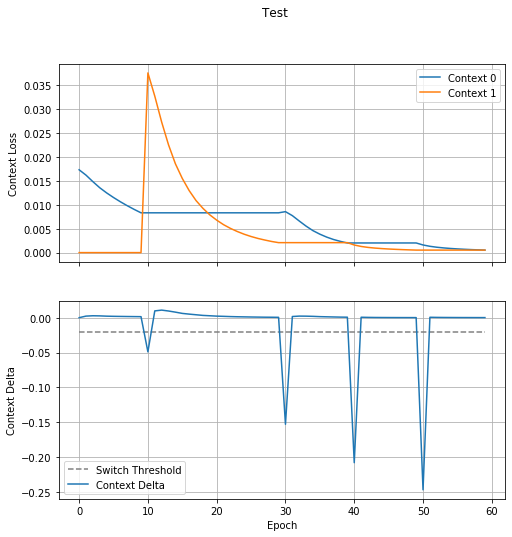

In [11]:
logger.plot(figsize=(8,8), title="Test")

#### Evaluation

In [21]:
batch_size = 1
display_predictions = True
verbose = 0

%time evaluate(model, x_train, y_train, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

array([[0.04025948],
       [0.96960604],
       [0.96226275],
       [0.03171104]], dtype=float32)
array([[0.97145987],
       [0.02444988],
       [0.03115296],
       [0.9637778 ]], dtype=float32)
CPU times: user 312 ms, sys: 15.6 ms, total: 328 ms
Wall time: 318 ms


[{'loss': 0.03566252812743187, 'binary_accuracy': 1.0},
 {'loss': 0.030563028529286385, 'binary_accuracy': 1.0}]

___

### 2. Dynamic n-task: (XOR, XNOR)

The following experiments demonstrates the model successfully learning two separate logic gates dynamically adding contexts to the layers.

In [7]:
TAG = "dynamic-2-gate"

#### Dataset

In [12]:
y_train = y_labels[:2]

#### Seeding

In [13]:
set_seed(5)

#### Model Creation

In [14]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size         = 128
num_contexts     = 1
max_contexts     = len(y_train)
switch_threshold = -0.02
add_threshold    = -0.04

# Create the model
model = create_model(TAG, optimizer, num_contexts=num_contexts, max_contexts=max_contexts, switch_threshold=switch_threshold, add_threshold=add_threshold)

Model: "n_task_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               384       
_________________________________________________________________
Gate_Context (Context)       (None, 128)               260       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 773
Trainable params: 513
Non-trainable params: 260
_________________________________________________________________


#### Training

In [15]:
cycles     = 3
epochs     = 10
batch_size = 1

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True  # Shuffle the contexts during training after first epoch
initial_task_shuffle = True  # Shuffle the contexts before training

verbose = Verbosity.Contexts

logger = AtrLogger()
callbacks = [logger]

# Benchmark the model
%time task_map, context_map = train(model, x_train, y_train, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)


[Gate_Context] Adding context 1

[Gate_Context] Switched context to 1

[Gate_Context] Switched context to 0

[Gate_Context] Switched context to 1

[Gate_Context] Switched context to 0
CPU times: user 1.06 s, sys: 156 ms, total: 1.22 s
Wall time: 1.01 s


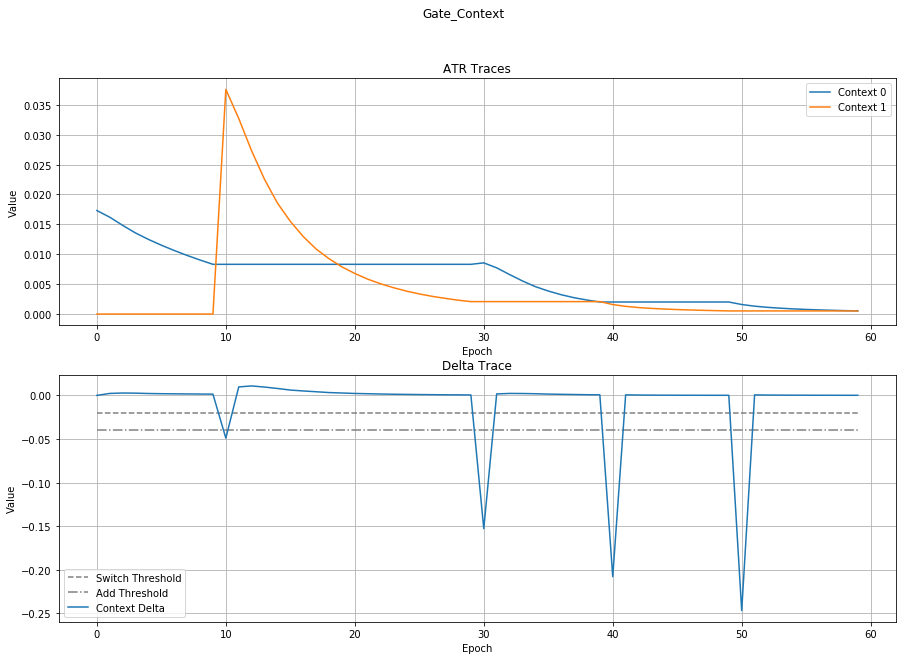

In [16]:
logger.plot(figsize=(15,10))

#### Evaluation

In [17]:
batch_size = 1
display_predictions = True
verbose = 0

%time evaluate(model, x_train, y_train, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

array([[0.04025948],
       [0.96960604],
       [0.96226275],
       [0.03171104]], dtype=float32)
array([[0.97145987],
       [0.02444988],
       [0.03115296],
       [0.9637778 ]], dtype=float32)
CPU times: user 375 ms, sys: 46.9 ms, total: 422 ms
Wall time: 320 ms


[{'loss': 0.03566252812743187, 'binary_accuracy': 1.0},
 {'loss': 0.030563028529286385, 'binary_accuracy': 1.0}]

___

### 3. Static n-task: All Gates

The following experiments demonstrates the model successfully learning two separate logic gates dynamically adding contexts to the layers.

In [28]:
TAG = "static-all-gates"

#### Dataset

In [45]:
y_train = y_labels[:]

#### Seeding

In [154]:
set_seed(10)

#### Model Creation

In [155]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size         = 256
num_contexts     = len(y_train)
switch_threshold = -0.02

# Create the model
model = create_model(TAG, optimizer, num_contexts=num_contexts, switch_threshold=switch_threshold)

Model: "n_task_model_550"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_551 (InputLayer)       [(None, 2)]               0         
_________________________________________________________________
dense_1100 (Dense)           (None, 256)               768       
_________________________________________________________________
Gate_Context (Context)       (None, 256)               2058      
_________________________________________________________________
dense_1101 (Dense)           (None, 1)                 257       
Total params: 3,083
Trainable params: 1,025
Non-trainable params: 2,058
_________________________________________________________________


#### Training

In [156]:
cycles     = 4
epochs     = 50
batch_size = 1

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True  # Shuffle the contexts during training after first epoch
initial_task_shuffle = True  # Shuffle the contexts before training

verbose = 0 # Verbosity.Contexts

logger = AtrLogger()
callbacks = [logger]

# Benchmark the model
%time history, evals, task_map, context_map = train(model, x_train, y_train, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)

CPU times: user 20.7 s, sys: 2.11 s, total: 22.8 s
Wall time: 18.8 s


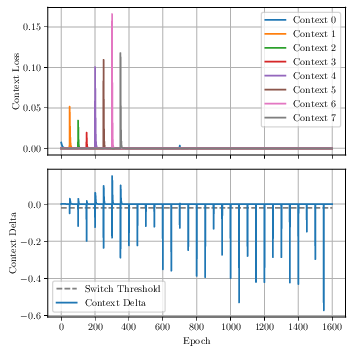

In [157]:
logger.plot(figsize=(5,5), savefile="graphs/gates_static.pgf")

#### Evaluation

In [123]:
batch_size = 1
display_predictions = True
verbose = 0

%time evaluate(model, x_train, y_train, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

array([[7.803738e-04],
       [9.992387e-01],
       [9.993854e-01],
       [9.251237e-04]], dtype=float32)
array([[9.9923587e-01],
       [6.2114000e-04],
       [1.1527538e-03],
       [9.9895316e-01]], dtype=float32)
array([[2.4768710e-04],
       [1.1353493e-03],
       [7.7986717e-04],
       [9.9973410e-01]], dtype=float32)
array([[6.7454576e-04],
       [9.9894172e-01],
       [9.9875891e-01],
       [9.9985683e-01]], dtype=float32)
array([[9.9984527e-01],
       [1.7899275e-04],
       [1.6361475e-04],
       [7.4774027e-04]], dtype=float32)
array([[9.9998826e-01],
       [9.9896419e-01],
       [9.9936175e-01],
       [3.1957030e-04]], dtype=float32)
array([[9.9993187e-01],
       [2.8568506e-04],
       [9.9962139e-01],
       [3.8182735e-04]], dtype=float32)
array([[1.6474724e-04],
       [9.9944079e-01],
       [5.1737334e-06],
       [9.9981809e-01]], dtype=float32)
CPU times: user 578 ms, sys: 0 ns, total: 578 ms
Wall time: 571 ms


[{'loss': 0.0007706278702244163, 'binary_accuracy': 1.0},
 {'loss': 0.000896663055755198, 'binary_accuracy': 1.0},
 {'loss': 0.0006074601551517844, 'binary_accuracy': 1.0},
 {'loss': 0.0007796664722263813, 'binary_accuracy': 1.0},
 {'loss': 0.0003113567072432488, 'binary_accuracy': 1.0},
 {'loss': 0.0005015541100874543, 'binary_accuracy': 1.0},
 {'loss': 0.0002785742108244449, 'binary_accuracy': 1.0},
 {'loss': 0.00022780026483815163, 'binary_accuracy': 1.0}]

___

### 4. Dynamic n-task: All Gates

The following experiments demonstrates the model successfully learning two separate logic gates dynamically adding contexts to the layers.

**NOTE:** The results to this task require some further analysis. I'm not certain what exactly the spikes really mean here, especially since they're displaying positive context-loss deltas. Also the fact that the first few tasks are initially learned using the very first context, and only later are things learned in their appropriate contexts.

In [28]:
TAG = "dynamic-all-gates"

#### Dataset

In [134]:
y_train = y_labels[:]

#### Seeding

In [150]:
set_seed(10)

#### Model Creation

In [151]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size         = 256
num_contexts     = 1
max_contexts     = len(y_train)
switch_threshold = -0.02
add_threshold    = -0.08

# Create the model
model = create_model(TAG, optimizer, num_contexts=num_contexts, max_contexts=max_contexts, switch_threshold=switch_threshold, add_threshold=add_threshold)

Model: "n_task_model_549"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_550 (InputLayer)       [(None, 2)]               0         
_________________________________________________________________
dense_1098 (Dense)           (None, 256)               768       
_________________________________________________________________
Gate_Context (Context)       (None, 256)               2058      
_________________________________________________________________
dense_1099 (Dense)           (None, 1)                 257       
Total params: 3,083
Trainable params: 1,025
Non-trainable params: 2,058
_________________________________________________________________


#### Training

In [152]:
cycles     = 4
epochs     = 50
batch_size = 1

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True  # Shuffle the contexts during training after first epoch
initial_task_shuffle = True  # Shuffle the contexts before training

# verbose = Verbosity.Contexts
verbose = 0

logger = AtrLogger()
callbacks = [logger]

# Benchmark the model
%time history, evals, task_map, context_map = train(model, x_train, y_train, cycles, epochs, task_shuffle, initial_task_shuffle, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=verbose)

CPU times: user 20.5 s, sys: 2.33 s, total: 22.8 s
Wall time: 19 s


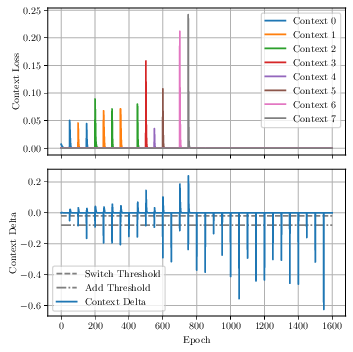

In [153]:
logger.plot(figsize=(5,5), savefile="graphs/gates_dynamic.pgf")

#### Evaluation

In [50]:
batch_size = 1
display_predictions = True
verbose = 0

%time evaluate(model, x_train, y_train, task_map, context_map, display_predictions, batch_size=batch_size, verbose=verbose)

array([[0.01206931],
       [0.9945443 ],
       [0.98673236],
       [0.00772402]], dtype=float32)
array([[0.9888005 ],
       [0.00694081],
       [0.005896  ],
       [0.98881596]], dtype=float32)
array([[3.1720102e-03],
       [2.4093986e-03],
       [3.0779069e-05],
       [9.9902356e-01]], dtype=float32)
array([[0.004026  ],
       [0.9935744 ],
       [0.9956422 ],
       [0.99976707]], dtype=float32)
array([[0.9994885 ],
       [0.00244954],
       [0.00384918],
       [0.00179839]], dtype=float32)
array([[0.999908  ],
       [0.9868336 ],
       [0.9979763 ],
       [0.00523409]], dtype=float32)
array([[0.9962155 ],
       [0.00109527],
       [0.99978715],
       [0.00170124]], dtype=float32)
array([[0.00145161],
       [0.997077  ],
       [0.00277025],
       [0.99786186]], dtype=float32)
CPU times: user 484 ms, sys: 62.5 ms, total: 547 ms
Wall time: 446 ms


[{'loss': 0.009680930525064468, 'binary_accuracy': 1.0},
 {'loss': 0.008847033604979515, 'binary_accuracy': 1.0},
 {'loss': 0.0016492930008098483, 'binary_accuracy': 1.0},
 {'loss': 0.0037701649125665426, 'binary_accuracy': 1.0},
 {'loss': 0.0021552317775785923, 'binary_accuracy': 1.0},
 {'loss': 0.005154831800609827, 'binary_accuracy': 1.0},
 {'loss': 0.0017007823335006833, 'binary_accuracy': 1.0},
 {'loss': 0.002323639113456011, 'binary_accuracy': 1.0}]

___

### 5. Static n-task Loss Over Time

This runs the static n-task logic gate experiment some number of times and calculates various statistics regarding the loss over time.

In [5]:
class AverageLossLogger(tf.keras.callbacks.Callback):
    def __init__(self, *args, **kwargs):
        super(AverageLossLogger, self).__init__(*args, **kwargs)
        self.atr_values = {}
        
    def set_model(self, model):
        if not isinstance(model, NTaskModel):
            return
        if model != self.model:
            for i in model.ctx_layers:
                layer = model.layers[i]
                if layer.atr_model is not None:
                    if i in self.atr_values:
                        self.atr_values[i].append([])
                    else:
                        self.atr_values[i] = [[]]
        super(AverageLossLogger, self).set_model(model)
        
    def on_epoch_end(self, batch, logs={}):
        for i in self.atr_values:
            layer = self.model.layers[i]
            self.atr_values[i][-1].append(tf.reduce_mean(layer.atr_model.values))

In [9]:
TAG = "static-all-gates"

#### Dataset

In [10]:
y_train = y_labels[:]

#### Seeding

In [11]:
set_seed(5)

#### Parameters/Model Settings

In [12]:
# Hyperparameters
hrr_size         = 256
num_contexts     = len(y_train)
switch_threshold = -0.02

cycles     = 2
epochs     = 50
batch_size = 1

shuffle              = True  # Shuffle the active context dataset during training
task_shuffle         = True  # Shuffle the contexts during training after first epoch
initial_task_shuffle = True  # Shuffle the contexts before training

In [13]:
history_list = []
eval_list = []
total_runs = 0

loss_logger = AverageLossLogger()

callbacks = [loss_logger]

In [14]:
runs = 50
for n in (1, 3, 6, 8):
    history_list.append([])
    eval_list.append([])
    for i in range(runs):

        print(i, end="\r")
        set_seed(i)

        # Optimizer
        optimizer = tf.keras.optimizers.SGD(1e-1)

        # Create the model
        model = create_model(TAG, optimizer, num_contexts=n, switch_threshold=switch_threshold, summary=False)

        # Train the model
        history, evals, task_map, context_map = train(model, x_train, y_train, cycles, epochs, task_shuffle, initial_task_shuffle, eval_after_cycle=True, batch_size=batch_size, shuffle=shuffle, callbacks=callbacks, verbose=0)

        history_list[-1].append([h for h in history])
        eval_list[-1].append([[d for d in evals[c]] for c in range(cycles)])
total_runs += runs
    

In [53]:
loss_np = 100*np.array([[[[d["binary_accuracy"] for d in c] for c in run] for run in m] for m in eval_list]).reshape((4, runs, num_contexts))

In [19]:
loss_np = 100*np.mean(np.array([[[d["binary_accuracy"] for d in c] for c in run] for run in eval_list]), axis=2)

In [21]:
losses = [[l for h in run for l in h.history["binary_accuracy"]] for run in history_list]

In [137]:
loss_np = np.array(losses)*100

In [133]:
loss_np = np.array(loss_logger.atr_values[2])

In [58]:
m = np.mean(loss_np, axis=(1,2))
m

array([50.   , 74.5  , 92.875, 99.75 ])

In [100]:
std = np.std(loss_np, axis=(1,2))
std

array([30.20761493, 25.18183869, 12.0875711 ,  2.48746859])

In [162]:
ci = 1.96 * std/np.sqrt(runs)
ci

array([8.37312367, 6.98004957, 3.35050377, 0.68949112])

In [163]:
def moving_average(a, n=80):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:] / n

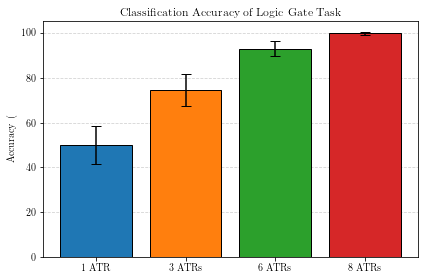

In [179]:
%matplotlib inline
fig, ax = plt.subplots()
labels = ["1 ATR", "3 ATRs", "6 ATRs", "8 ATRs"]
x_pos = np.arange(len(labels))
ax.grid(True, axis='y', linestyle='--', color='lightgrey', zorder=0)
for x, label in enumerate(labels):
    ax.bar(x, m[x], yerr=ci[x], capsize=5, edgecolor='black', zorder=3)
ax.set_ylabel("Accuracy (%)")
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title("Classification Accuracy of Logic Gate Task")
plt.tight_layout()
plt.savefig("graphs/accuracy.pgf")

In [182]:
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low))

In [199]:
np.mean(loss_np, axis=2).shape

(4, 50)

In [197]:
data = [row for row in np.mean(loss_np, axis=2)]

In [201]:
import pickle

In [203]:
with open("logic_gate_runs.dat", 'wb') as f:
    pickle.dump(data, f)

In [ ]:
with open("logic_gate_runs")

BrokenPipeError: [Errno 32] Broken pipe

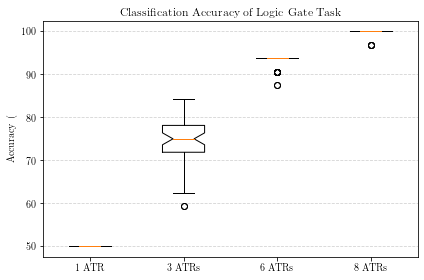

In [200]:
%matplotlib inline
fig, ax = plt.subplots()
labels = ["1 ATR", "3 ATRs", "6 ATRs", "8 ATRs"]
x_pos = np.arange(1, len(labels)+1)
ax.grid(True, axis='y', linestyle='--', color='lightgrey', zorder=0)
# for x, label in enumerate(labels):
ax.boxplot(data, notch=True, zorder=3)
ax.set_ylabel("Accuracy (%)")
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title("Classification Accuracy of Logic Gate Task")
plt.tight_layout()
plt.savefig("graphs/accuracy.pgf")

In [176]:
loss_np.reshape((4,50*8))

array([[ 25.,  75.,  50., ...,   0.,  25.,  75.],
       [100.,  75.,  25., ..., 100., 100.,  25.],
       [100.,  75., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]])